# Multi-Shell Free Water Elimination using MT-CSD

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

/home/therauser/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [2]:
scheme_hcp.print_acquisition_info

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 18
number of DWI shells: 3

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |1000            |56                       |10.6       |43.1      |N/A  
2           |90        |2000            |79                       |10.6       |43.1      |N/A  
3           |90        |3000            |97                       |10.6       |43.1      |N/A  


In [3]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
wm, gm, csf, selection_map = three_tissue_response_dhollander16(
    scheme_hcp, data_hcp, wm_algorithm='tournier07',
    wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)
tissue_response = [wm, gm, csf]

## Synthetic Study on Expected Effect on MAP-MRI Indices

In [30]:
from dmipy.core.acquisition_scheme import gtab_mipy2dipy
from dipy.reconst.mapmri import MapmriModel
gtab = gtab_mipy2dipy(scheme_hcp)
mapmod = MapmriModel(gtab)

In [5]:
import numpy as np
def generate_synthetic_multi_tissue_data(acquisition_scheme, tissue_responses, fractions=None):
    "Function to generate synthetic data from given tissue responses"
    if fractions is None:
        fractions = np.random.rand(len(tissue_responses))
        fractions /= fractions.sum()
    data = 0.
    for vf, response in zip(fractions, tissue_responses):
        data += vf * response.S0_response * response(acquisition_scheme, mu=[0., 0.])
    data =  np.array([data])
    return fractions, data

In [56]:
from dipy.sims.phantom import add_noise
fr_wm_gm = np.linspace(0, 1, 11)
fr_csf = fr_wm_gm[::-1]
fractions_wm_csf = np.zeros((11, 3))
fractions_wm_csf[:, 0] = fr_wm_gm
fractions_wm_csf[:, 2] = fr_csf

fractions_gm_csf = np.zeros((11, 3))
fractions_gm_csf[:, 1] = fr_wm_gm
fractions_gm_csf[:, 2] = fr_csf

data_wm_csf = []
data_gm_csf = []
for fractions in fractions_wm_csf:
    _, data = generate_synthetic_multi_tissue_data(scheme_hcp, tissue_response, fractions)
    data_wm_csf.append(data)
for fractions in fractions_gm_csf:
    _, data = generate_synthetic_multi_tissue_data(scheme_hcp, tissue_response, fractions)
    data_gm_csf.append(data)

data_wm_csf_stack = add_noise(np.tile(data_wm_csf, (50, 1)), snr=200)
data_gm_csf_stack = add_noise(np.tile(data_gm_csf, (50, 1)), snr=200)

In [57]:
mtcsd_mod_3shell = (
    MultiCompartmentSphericalHarmonicsModel(tissue_response))
mtcsf_fit_wm = mtcsd_mod_3shell.fit(scheme_hcp, data_wm_csf_stack, fit_S0_response=True, verbose=False)
mtcsf_fit_gm = mtcsd_mod_3shell.fit(scheme_hcp, data_gm_csf_stack, fit_S0_response=True, verbose=False)

In [70]:
csf.S0_response

10908.432

In [71]:
wm.S0_response

3184.1763

In [69]:
mtcsf_fit_wm.return_filtered_signal(['partial_volume_2'])

array([[[10923.33177801,   761.95519025,   347.95466483, ...,
           760.42596558,   347.15807108,   334.64095626],
        [10919.03320914,   760.42292757,   346.89680486, ...,
           761.79920235,   345.03788989,   332.98578996],
        [10889.74314122,   755.55852971,   342.74516402, ...,
           756.72388576,   342.23825368,   330.43677403],
        ...,
        [10927.65845398,   768.97696946,   352.38781173, ...,
           766.67474103,   351.15450094,   339.31013625],
        [10895.44989338,   763.81446172,   353.28113956, ...,
           773.16450458,   349.89305297,   337.6427297 ],
        [10910.08213745,   757.05318603,   343.20962746, ...,
           757.05318603,   343.20962746,   330.40056027]],

       [[10143.20200242,   906.9868857 ,   456.15412985, ...,
           813.81003683,   491.00216523,   373.31064488],
        [10134.33855234,   900.17547792,   461.00776904, ...,
           811.17217048,   484.15142239,   377.72529557],
        [10123.90296023, 

In [ ]:
# doesn't work yet it seems.

In [58]:
data_wm_csf_filtered = mtcsf_fit_wm.return_filtered_signal(['partial_volume_2'])
data_gm_csf_filtered = mtcsf_fit_gm.return_filtered_signal(['partial_volume_2'])

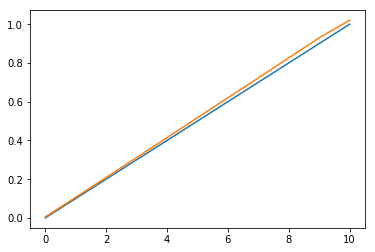

In [59]:
plt.plot(fr_wm_gm)
plt.plot(np.mean(mtcsf_fit_wm.fitted_parameters['partial_volume_0'], axis=1))

In [60]:
mapfit_wm_raw = mapmod.fit(data_wm_csf_stack)
mapfit_wm_filtered = mapmod.fit(data_wm_csf_filtered)
mapfit_gm_raw = mapmod.fit(data_gm_csf_stack)
mapfit_gm_filtered = mapmod.fit(data_gm_csf_filtered)

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

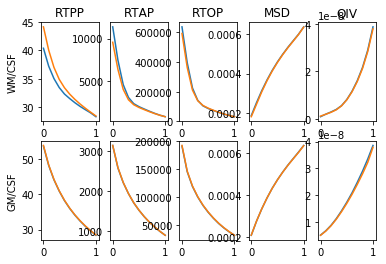

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=5)
axs = axs.ravel()

axs[0].set_title('RTPP')
axs[1].set_title('RTAP')
axs[2].set_title('RTOP')
axs[3].set_title('MSD')
axs[4].set_title('QIV')
axs[0].set_ylabel('WM/CSF')
axs[5].set_ylabel('GM/CSF')

#wm
axs[0].plot(fr_csf, np.mean(mapfit_wm_raw.rtpp(), axis=1))
axs[0].plot(fr_csf, np.mean(mapfit_wm_filtered.rtpp(), axis=1))
axs[1].plot(fr_csf, np.mean(mapfit_wm_raw.rtap(), axis=1))
axs[1].plot(fr_csf, np.mean(mapfit_wm_filtered.rtap(), axis=1))
axs[2].plot(fr_csf, np.mean(mapfit_wm_raw.rtop(), axis=1))
axs[2].plot(fr_csf, np.mean(mapfit_wm_filtered.rtop(), axis=1))
axs[3].plot(fr_csf, np.mean(mapfit_wm_raw.msd(), axis=1))
axs[3].plot(fr_csf, np.mean(mapfit_wm_filtered.msd(), axis=1))
axs[4].plot(fr_csf, np.mean(mapfit_wm_raw.qiv(), axis=1))
axs[4].plot(fr_csf, np.mean(mapfit_wm_filtered.qiv(), axis=1))

#gm
axs[5].plot(fr_csf, np.mean(mapfit_gm_raw.rtpp(), axis=1))
axs[5].plot(fr_csf, np.mean(mapfit_gm_filtered.rtpp(), axis=1))
axs[6].plot(fr_csf, np.mean(mapfit_gm_raw.rtap(), axis=1))
axs[6].plot(fr_csf, np.mean(mapfit_gm_filtered.rtap(), axis=1))
axs[7].plot(fr_csf, np.mean(mapfit_gm_raw.rtop(), axis=1))
axs[7].plot(fr_csf, np.mean(mapfit_gm_filtered.rtop(), axis=1))
axs[8].plot(fr_csf, np.mean(mapfit_gm_raw.msd(), axis=1))
axs[8].plot(fr_csf, np.mean(mapfit_gm_filtered.msd(), axis=1))
axs[9].plot(fr_csf, np.mean(mapfit_gm_raw.qiv(), axis=1))
axs[9].plot(fr_csf, np.mean(mapfit_gm_filtered.qiv(), axis=1))

In [4]:
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel
# we also fit the MT-CSD model to the multi-shell data as comparison
mtcsd_mod_3shell = (
    MultiCompartmentSphericalHarmonicsModel(tissue_response))
mtcsd_fit_3shell = mtcsd_mod_3shell.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0, fit_S0_response=True)

Setup CVXPY FOD optimizer in 0.00522208213806 seconds
Using parallel processing with 8 workers.
Fitting of 8181 voxels complete in 256.407802105 seconds.
Average of 0.0313418655549 seconds per voxel.


In [5]:
data_hcp_csf_filtered = mtcsd_fit_3shell.return_filtered_signal(['partial_volume_2'])

In [7]:
mapfit_raw = mapmod.fit(data_hcp, mask=data_hcp[..., 0]>0)
mapfit_filtered = mapmod.fit(data_hcp_csf_filtered, mask=data_hcp_csf_filtered[..., 0]>0)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

(-0.5, 144.5, -0.5, 144.5)

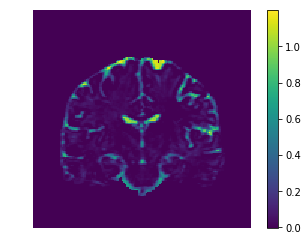

In [19]:
plt.imshow(mtcsd_fit_3shell.fitted_parameters['partial_volume_2'].squeeze().T, origin=True)
plt.colorbar()
plt.axis('off')

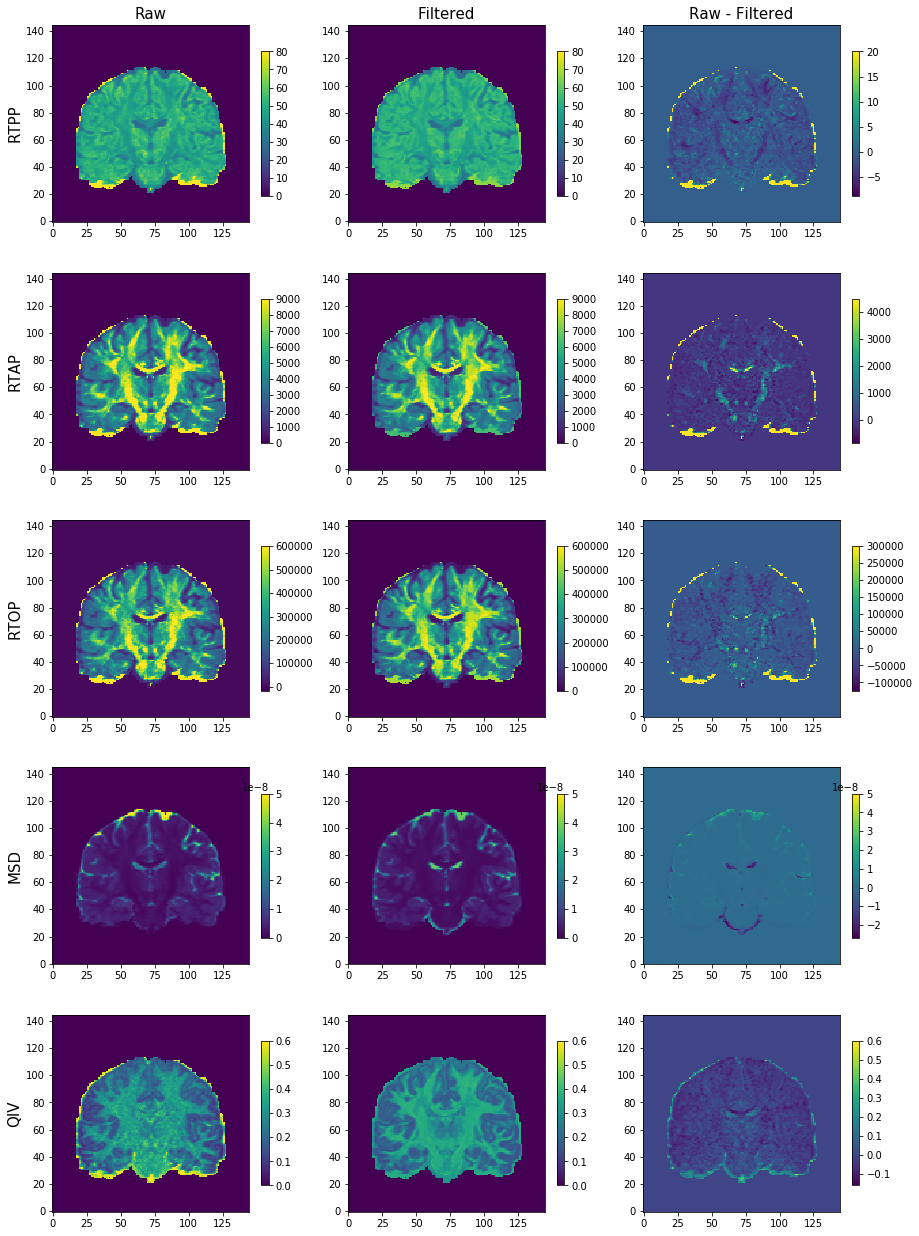

In [27]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=[15, 22])
axs = axs.ravel()

im = axs[0].imshow(mapfit_raw.rtpp().squeeze().T, origin=True, vmax=80)
fig.colorbar(im, ax=axs[0], shrink=0.7)
im = axs[1].imshow(mapfit_filtered.rtpp().squeeze().T, origin=True, vmax=80)
fig.colorbar(im, ax=axs[1], shrink=0.7)
im = axs[2].imshow((mapfit_raw.rtpp().squeeze() - mapfit_filtered.rtpp().squeeze()).T, origin=True, vmax=20)
fig.colorbar(im, ax=axs[2], shrink=0.7)
im = axs[3].imshow(mapfit_raw.rtap().squeeze().T, origin=True, vmax=9e3)
fig.colorbar(im, ax=axs[3], shrink=0.7)
im = axs[4].imshow(mapfit_filtered.rtap().squeeze().T, origin=True, vmax=9e3)
fig.colorbar(im, ax=axs[4], shrink=0.7)
im = axs[5].imshow((mapfit_raw.rtap().squeeze() - mapfit_filtered.rtap().squeeze()).T, origin=True, vmax=4.5e3)
fig.colorbar(im, ax=axs[5], shrink=0.7)
im = axs[6].imshow(mapfit_raw.rtop().squeeze().T, origin=True, vmax=6e5)
fig.colorbar(im, ax=axs[6], shrink=0.7)
im = axs[7].imshow(mapfit_filtered.rtop().squeeze().T, origin=True, vmax=6e5)
fig.colorbar(im, ax=axs[7], shrink=0.7)
im = axs[8].imshow((mapfit_raw.rtop().squeeze() - mapfit_filtered.rtop().squeeze()).T, origin=True, vmax=3e5)
fig.colorbar(im, ax=axs[8], shrink=0.7)
im = axs[9].imshow(mapfit_raw.qiv().squeeze().T, origin=True, vmax=5e-8)
fig.colorbar(im, ax=axs[9], shrink=0.7)
im = axs[10].imshow(mapfit_filtered.qiv().squeeze().T, origin=True, vmax=5e-8)
fig.colorbar(im, ax=axs[10], shrink=0.7)
im = axs[11].imshow((mapfit_raw.qiv().squeeze() - mapfit_filtered.qiv().squeeze()).T, origin=True, vmax=5e-8)
fig.colorbar(im, ax=axs[11], shrink=0.7)
im = axs[12].imshow(mapfit_raw.ng().squeeze().T, origin=True, vmax=0.6)
fig.colorbar(im, ax=axs[12], shrink=0.7)
im = axs[13].imshow(mapfit_filtered.ng().squeeze().T, origin=True, vmax=0.6)
fig.colorbar(im, ax=axs[13], shrink=0.7)
im = axs[14].imshow((mapfit_raw.ng().squeeze() - mapfit_filtered.ng().squeeze()).T, origin=True, vmax=0.6)
fig.colorbar(im, ax=axs[14], shrink=0.7)
axs[0].set_title('Raw', fontsize=15)
axs[1].set_title('Filtered', fontsize=15)
axs[2].set_title('Raw - Filtered', fontsize=15)
axs[0].set_ylabel('RTPP', fontsize=15)
axs[3].set_ylabel('RTAP', fontsize=15)
axs[6].set_ylabel('RTOP', fontsize=15)
axs[9].set_ylabel('MSD', fontsize=15)
axs[12].set_ylabel('QIV', fontsize=15);